# 1. Setup

In [91]:
import tensorflow as tf
import os

In [92]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [93]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Data Cleaning

In [94]:
import cv2
import imghdr

In [95]:
data_dir = r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\healthy_and_wilted_houseplants\houseplant_images' 

In [96]:
os.listdir(data_dir)

['roomplant_healthy', 'roomplant_wilted']

In [10]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [16]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list C:\Users\Marvin\Documents\WBS\Final_Project\Data\healthy_and_wilted_houseplants\houseplant_images\healthy\healthy_158.jpg
Image not in ext list C:\Users\Marvin\Documents\WBS\Final_Project\Data\healthy_and_wilted_houseplants\houseplant_images\healthy\healthy_278.jpg


# 3. Load Data

In [97]:
import numpy as np
from matplotlib import pyplot as plt

In [115]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 902 files belonging to 2 classes.


In [99]:
data_iterator = data.as_numpy_iterator()

In [119]:
batch = data_iterator.next()

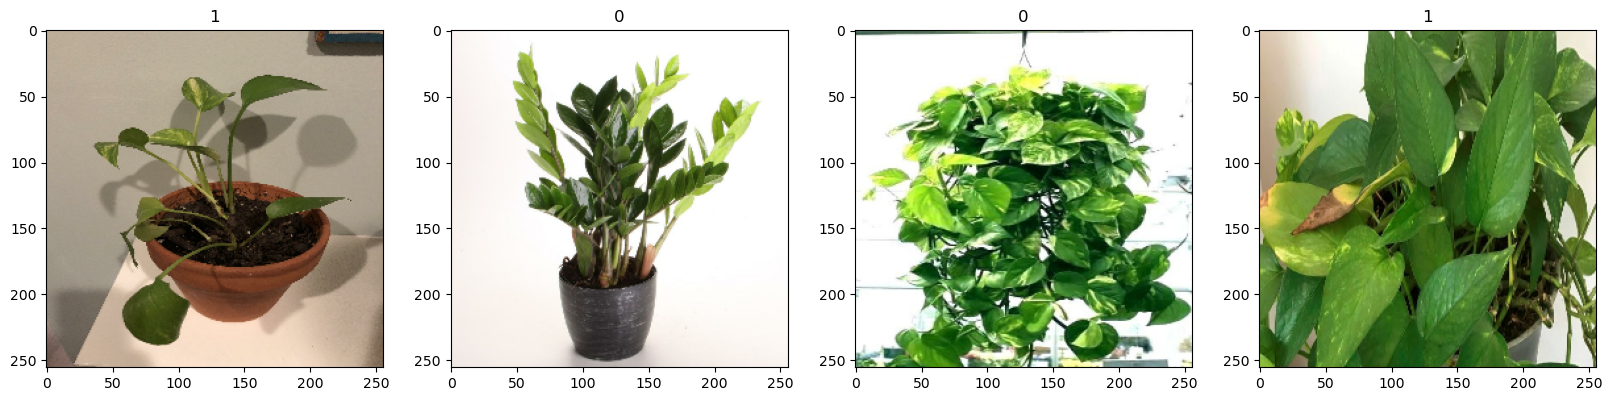

In [120]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Preprocess

### 4.1. Scaling

In [121]:
data_scaled = data.map(lambda x,y: (x/255, y))

In [117]:
data_scaled.as_numpy_iterator().next()

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [0.00000000e+00, 0.00000000e+00, 0.0000

In [122]:
# validate scaling 0-1

scaled_iterator = data_scaled.as_numpy_iterator()
batch_scaled = scaled_iterator.next()
batch_scaled[0].max()

1.0

### 4.2. Splitting

In [37]:
train_size = int(len(data_scaled)*.7)
val_size = int(len(data_scaled)*.2)
test_size = int(len(data_scaled)*.1)

In [40]:
test_size

2

In [41]:
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

# 5. Deep Learning Model

### 5.1. Building

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [43]:
model = Sequential()

In [46]:
# layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### 5.2. Training

In [63]:
logdir=r'C:\Users\Marvin\Documents\WBS\Final_Project\logs'

In [64]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [65]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25


20/20 [==============================] - 4s 203ms/step - loss: 1.6389e-04 - accuracy: 1.0000 - val_loss: 0.1671 - val_accuracy: 0.9875
Epoch 2/25
20/20 [==============================] - 4s 203ms/step - loss: 1.2780e-04 - accuracy: 1.0000 - val_loss: 0.0171 - val_accuracy: 0.9937
Epoch 3/25
20/20 [==============================] - 4s 203ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/25
20/20 [==============================] - 4s 202ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9875
Epoch 5/25
20/20 [==============================] - 4s 203ms/step - loss: 8.9125e-04 - accuracy: 1.0000 - val_loss: 0.0918 - val_accuracy: 0.9937
Epoch 6/25
20/20 [==============================] - 4s 198ms/step - loss: 9.2826e-04 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 0.9812
Epoch 7/25
20/20 [==============================] - 4s 199ms/step - loss: 2.6636e-04 - accuracy: 1.0000 - val_loss: 0.1567 - val_accuracy: 0.98

### 5.3. Performance

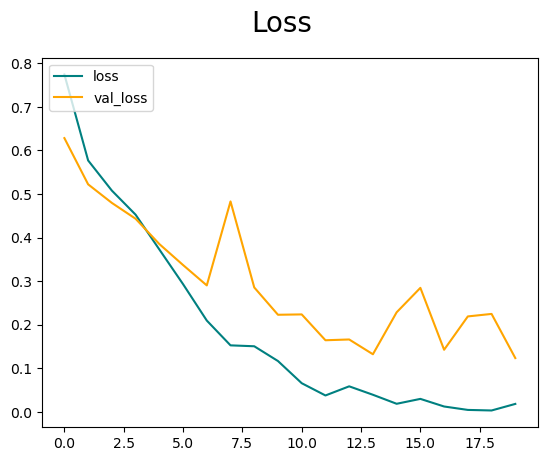

In [53]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

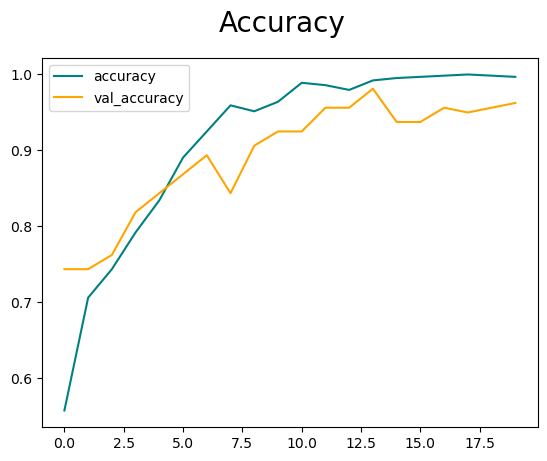

In [54]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 5.4. Evaluation

In [66]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [67]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [68]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 23ms/step


In [69]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


### 5.5. Testing

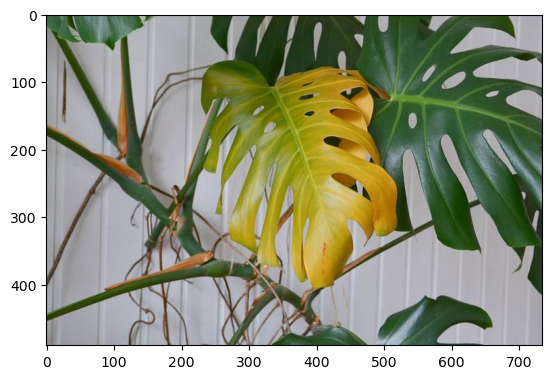

In [76]:
img = cv2.imread(r'C:\Users\Marvin\Documents\WBS\Final_Project\Data\healthy_and_wilted_houseplants\wilted_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

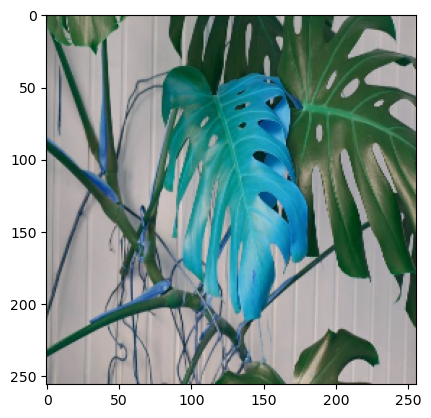

In [77]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [78]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [79]:
yhat

array([[0.999998]], dtype=float32)

In [80]:
if yhat > 0.5: 
    print(f'Predicted class is wilted')
else:
    print(f'Predicted class is healthy')

Predicted class is wilted


# 6. Save the Model

In [81]:
from tensorflow.keras.models import load_model

In [83]:
model.save(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','healthy_or_wilted_classifier.h5'))

In [86]:
new_model = load_model(os.path.join(r'C:\Users\Marvin\Documents\WBS\Final_Project\Dr.-Greenthumb-Decoding-Nature-s-Needs\Models','healthy_or_wilted_classifier.h5'))

In [87]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 56ms/step


array([[0.999998]], dtype=float32)